```

                                     Monte-Carlo Dropout Regularization
```


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.distributions import Bernoulli


## [Dropout as a Bayesian Approximation : Representing Uncertainty in Deeep Learning](https://arxiv.org/pdf/1506.02142.pdf)

### During NN optimisation a regularisation term is
### often added. We often use L2 regularisation weighted by
### some weight decay λ, resulting in a minimisation objective
### (often referred to as cost),

## $$ L_{dropout} := \frac{1}{N}  \sum_1^N E(y_i,\hat{y_i}) + λ\sum_1^L (\|W_i\|_2^2  +  \|b_i\|_2^2)              $$


### With dropout, we sample binary variables for every input
### point and for every network unit in each layer (apart from
### the last one). Each binary variable takes value 1 with probability
### pi for layer i. A unit is dropped (i.e. its value is set
### to zero) for a given input if its corresponding binary variable
### takes value 0. We use the same values in the backward
### pass propagating the derivatives to the parameters.



## Bernoulli Distribution

![](https://wikimedia.org/api/rest_v1/media/math/render/svg/8454ef9d4b6d25620cd9372fb3cae28491f318d7)


![](https://wikimedia.org/api/rest_v1/media/math/render/svg/614e0c64d59f0ff2e926deafcb2de6e502394fac)


###  We use q(ω), a distribution over matrices whose
### columns are randomly set to zero, to approximate the intractable
### posterior. We define q(ω) as :
## $$W_i = M_i * diag([z_i,j]_{j=1}^{K_i})  $$


.......

given some probabilities pi and matrices Mi as variational
parameters. The binary variable zi,j = 0 corresponds then
to unit j in layer i − 1 being dropped out as an input to
layer i. The variational distribution q(ω) is highly multimodal,
inducing strong joint correlations over the rows of
the matrices Wi (which correspond to the frequencies in
the sparse spectrum GP approximation



.........


## $$ L_{GP-MC}             $$


In [40]:
class VariationalDense:
    """
    Variational Dense layer  Class
    n_in : number of inputs of hidden layer
    n_out : number of outputs of hidden layer
    model_lam : regularization parameter
    model_prob : bernoulli random  probability of keeping the synapses between neurons
    
    """
    def __init__(self,n_in , n_out, model_prob,model_lam):
        self.model_prob = model_prob
        self.model_lam = model_lam
        self.model_bern = Bernoulli(probs = self.model_prob, dtype = tf.float32)
        self.model_M = tf.Variable(tf.truncated_normal([n_in , n_out], stddev = 0.01))
        self.model_m = tf.Variable(tf.zeros([n_out]))
        self.model_W = tf.matmul(
            tf.diag(self.model_bern.sample((n_in , ))),  self.model_M
        )
        
        
    def __call__(self, X, activation = tf.identity):
        output = activation(tf.matmul(X, self.model_W) + self.model_m)
        if self.model_M.shape[1] == 1:
            output = tf.squeeze(output)
            
        return output



    @property
    def regularization(self):
        return self.model_lam * (
            self.model_prob * tf.reduce_sum(tf.square(self.model_M)) + 
            tf.reduce_sum(tf.square(self.model_m))
        
        )
    
    
# Created smaple data

n_samples = 20
X  = np.random.normal( size = (n_samples, 1))
y  = np.random.normal((np.cos(5.*X) / np.abs(X) + 1.), 0.1).ravel()
X_pred = np.atleast_2d(np.linspace(-3., 3., num = 100)).T
X = np.hstack((X , X**2 , X**3))
X_pred = np.hstack((X_pred , X_pred**2 , X_pred**3))





# Create the Tnesorflow Model

n_feats = X.shape[1]
n_hidden = 100
model_prob = 0.9
model_lam = 1e-2
model_X = tf.placeholder(tf.float32, [None, n_feats])
model_y =tf.placeholder(tf.float32, [None])
model_L_1 = VariationalDense(n_feats , n_hidden , model_prob , model_lam)
model_L_2 = VariationalDense(n_hidden , n_hidden , model_prob , model_lam)
model_L_3 = VariationalDense(n_hidden , 1, model_prob , model_lam)

model_out_1 = model_L_1(model_X , tf.nn.relu)
model_out_2 = model_L_2(model_out_1 , tf.nn.relu)
model_pred = model_L_3(model_out_2)
model_sse = tf.reduce_sum(tf.square(model_y - model_pred))
model_mse = model_sse / n_samples
model_loss = (
    # Negative log-likelihood
    model_sse +
    # Regularization
    model_L_1.regularization +
    model_L_2.regularization + 
    model_L_3.regularization 
    
    )/n_samples
    
train_step = tf.train.AdamOptimizer(1e-3).minimize(model_loss)



with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(10000):
        sess.run(train_step ,{ model_X: X, model_y: y})
        if i % 100 == 0:
            mse = sess.run(model_mse,{model_X:X , model_y: y })
            print("Iteration {}. Mean Squared error: {:.4f}.".format(i, mse))
 

    # Sample from the posterior
    n_post = 1000
    Y_post = np.zeros((n_post , X_pred.shape[0]))
    for i in range(n_post):
        Y_post[i] = sess.run(model_pred, {model_X: X_pred})
    
    

    

Iteration 0. Mean Squared error: 32.6339.
Iteration 100. Mean Squared error: 22.9937.
Iteration 200. Mean Squared error: 30.2713.
Iteration 300. Mean Squared error: 16.7667.
Iteration 400. Mean Squared error: 13.4532.
Iteration 500. Mean Squared error: 12.3966.
Iteration 600. Mean Squared error: 9.7740.
Iteration 700. Mean Squared error: 8.1685.
Iteration 800. Mean Squared error: 36.1403.
Iteration 900. Mean Squared error: 37.0634.
Iteration 1000. Mean Squared error: 6.2605.
Iteration 1100. Mean Squared error: 6.0453.
Iteration 1200. Mean Squared error: 7.3320.
Iteration 1300. Mean Squared error: 5.8266.
Iteration 1400. Mean Squared error: 8.1949.
Iteration 1500. Mean Squared error: 105.3524.
Iteration 1600. Mean Squared error: 2.6086.
Iteration 1700. Mean Squared error: 3.5870.
Iteration 1800. Mean Squared error: 2.1488.
Iteration 1900. Mean Squared error: 4.0405.
Iteration 2000. Mean Squared error: 6.5903.
Iteration 2100. Mean Squared error: 4.2683.
Iteration 2200. Mean Squared error

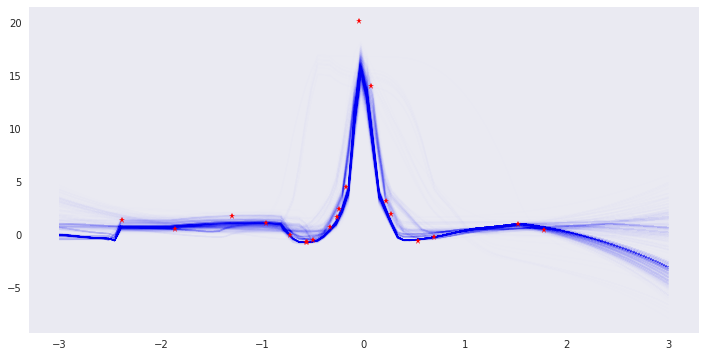

In [43]:
plt.rcParams['figure.figsize'] = (12,6)
if True:
    
    for i in range(n_post):
        plt.plot(X_pred[:,0], Y_post[i], "b-" , alpha = 1. / 200)
       
    plt.plot(X[:,0], y, "r*")
    plt.grid()
    plt.show()